### Description of the environment

We want to simulate driving a car in a way that is as fuel efficient as possible. To carry out the simulation I had to model a real scenario with some simplifications. Next we are going to see how our environment would be expressed mathematically.

MDP:

States $S = \{Position~(meters), Speed~(km/h), Gear, Revolutions~(RPM), Consume~(L/100km)~and~Limit~(km/h) \}$

Actions $A =  \{Accelerate, don't~accelerate, deaccelerate, gear~up, gear~down\}$

Reward $R = \left\lbrace\begin{array}{l}   -speed-limit~~~~~~~~~~~~~~~~~~~if~~
speed > limit \\ -\frac{revolutions}{\beta_1}-speed \cdot \beta_2~~~~~if~revolutions < 2000~or~~
revolutions > 3000\\ \alpha \cdot speed-consume~~~~~~~~~~otherwise \end{array}\right.$


**Update function:**

We increase or decrease the speed by 6 in every step

**Speed:** speed += (action - 1) * (6)


We calculate the revolutions depending on the speed and the gear

**Revolutions:** revolutions = (self.gear_r[int(gear-1)] * 4.64 * speed * 1000)/(1.83*60)

Obtained from the formula: $ Speed =\frac{C_r \cdot 60 \cdot RPM/1000}{R_m \cdot RDF} $ 

Where $C_r$ is the circunference of the wheel, RPM (Revolutions per minute), $R_M$ relation between gears and $RDF$ is the gears group relation.

I've taken some data from the link but the relation between gears have been modified by me:

self.gear_r = [2.5, 1.4,0.9,0.7,0.55,0.45]

But the $RDF$ and $C_r$ is the same as in the following link: (They use a volkswagen golf as a reference)

https://automercado.files.wordpress.com/2017/12/datos-caja-cambios-020-vw-golf-gti-relacic3b3n-cerr-gr-a-14x65.pdf


We calculate the consume depending on the speed and gear

**Consume:**
```
        if gear == 1:
            consume = 0.0059*speed**2-0.1857*speed+11.0892
        elif gear == 2:
            consume = 0.0012*speed**2-0.0574*speed+6.6088
        elif gear == 3:
            consume = 0.0005*speed**2-0.0207*speed+4.5582
        elif gear == 4:
            consume = 0.0004*speed**2-0.0216*speed+4.1160
        elif gear == 5:
            consume = 0.0004*speed**2-0.0183*speed+3.6267
        elif gear == 6:
            consume = 0.0004*speed**2-0.0198*speed+3.4347
````
Approximating this function:

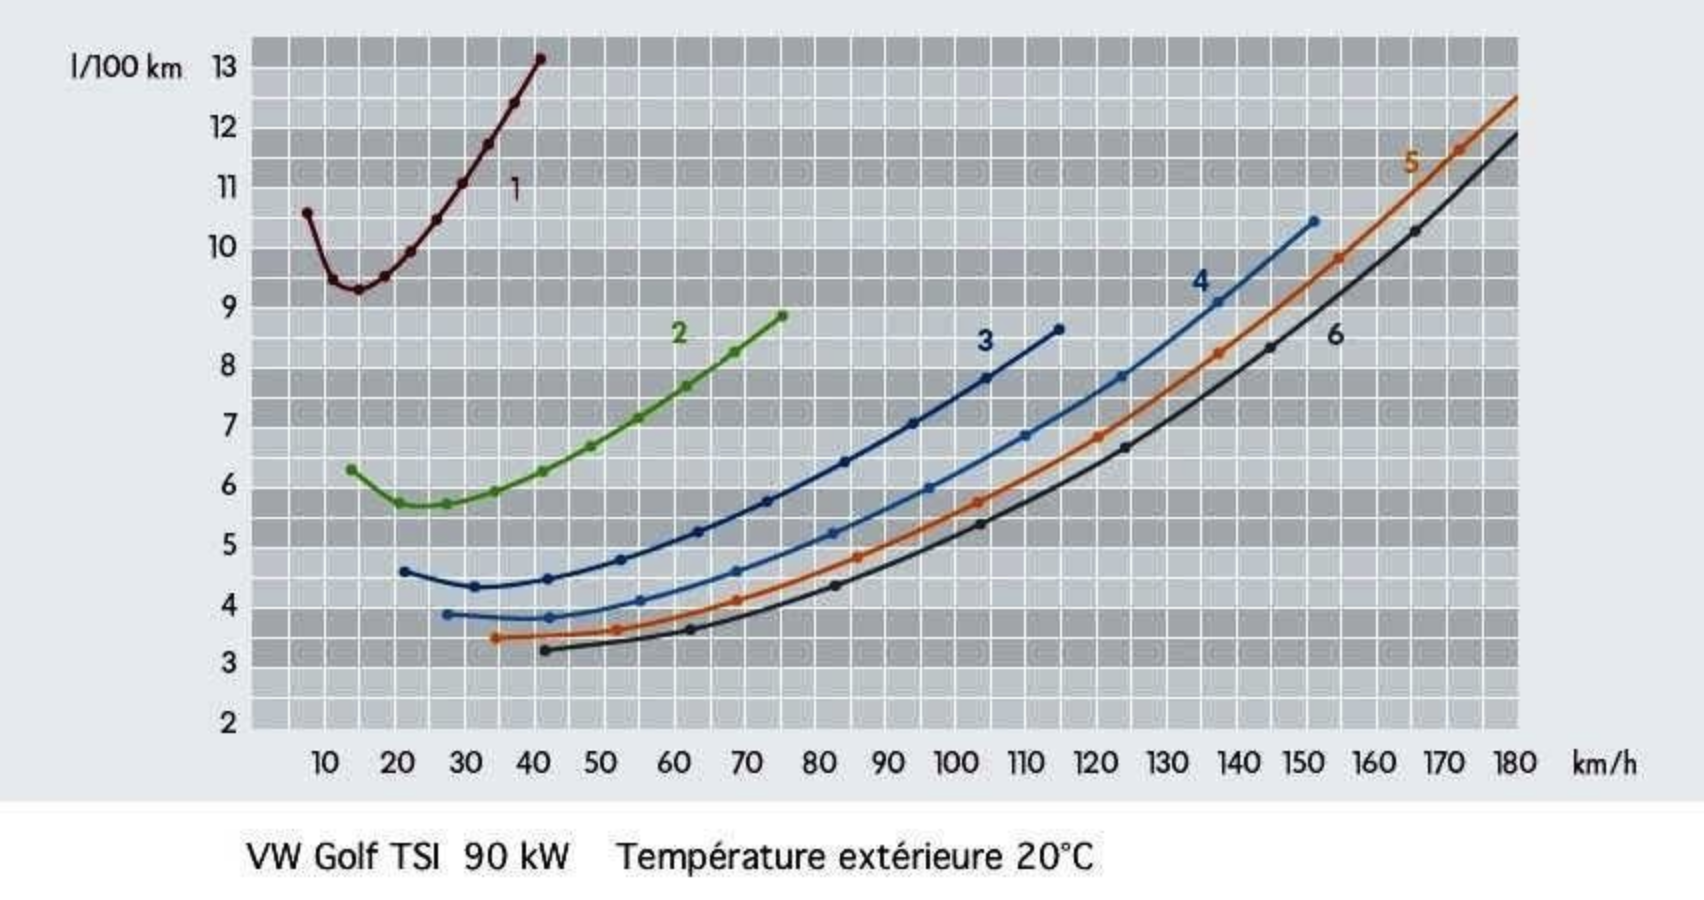

Finally, we update the position (converting for km/h to m/s as the position is in meters).

**Position:**  position += speed*0.2778

More details in the python file ```FuelCar.py```



## Compute infrastructure

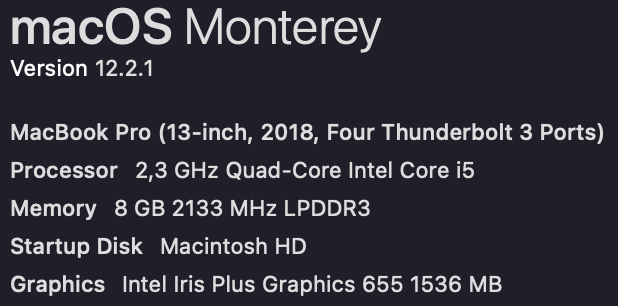

In [1]:
import warnings
warnings.filterwarnings('ignore')
import gym_fuel
import gym
from matplotlib import pyplot as plt
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN
from stable_baselines.common.evaluation import evaluate_policy
import numpy as np



env = gym.make("Fuel-v0")
%matplotlib inline 

In [2]:
def evaluate(model, num_episodes=100, deterministic = True):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        episode_len = 0
        # we finish the episode when the length is more than 4000 or when done
        while not done and episode_len < 4000:
            episode_len += 1
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs, deterministic = deterministic)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))
    print(all_episode_rewards)
    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In [3]:
def evaluate_to_plot(model,env, num_episodes=100, deterministic = True):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    
    all_episode_rewards = []
    all_episode_rewards_array = []
    seeds = range(num_episodes)
    for i in range(num_episodes):
        env.seed(seeds[i])
        episode_rewards = []
        done = False
        obs = env.reset()
        episode_len = 0
        # we finish the episode when the length is more than 4000 or when done
        while not done and episode_len < 4000:
            episode_len += 1
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs, deterministic = deterministic)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))
        all_episode_rewards_array.append(episode_rewards)
    print(all_episode_rewards)
    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward, all_episode_rewards_array

## Evaluation of the environment

First of all we are going to compare a random agent with one that can learn and see if we can really get good results in our environment.

In [11]:
# this is the random policy
seeds = [12345, 54321, 12345321]
mean_reward_before_train = {}
for seed in seeds:
    model = DQN(MlpPolicy, env, seed=seed, n_cpu_tf_sess=1)
    mean_reward_before_train[str(seed)] = evaluate(model)

[-44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044,

[-44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044,

[-44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044,

In [12]:
mean_reward_after_train = {}
for seed in seeds:
    model = DQN(MlpPolicy, env, seed=seed, n_cpu_tf_sess=1)
    model.learn(total_timesteps=25000)
    mean_reward_after_train[str(seed)] = evaluate(model, num_episodes=50)

[41021.31087868877, 27023.063897814383, 16174.902891803262, 26214.772924043766, 40142.234714754304, -40324.74691202205, 11899.67125956283, 4571.354744262272, 8109.099011475417, 9407.662348633898, 42576.25292513697, 16589.53898961747, 11167.235304371596, 9207.23413879783, 12362.40573825134, 5413.557050273181, 25930.8444256831, 42572.59652513697, 42546.64532513697, 6028.721295081923, 27076.607097814383, 27076.607097814383, 40366.53727868874, -40331.70598633899, 8071.507831147543, 41021.31087868877, 40647.16687868875, 16543.34365792348, 9407.662348633898, 26312.56747814228, 8546.761479781426, -40324.74691202205, 11459.383744808747, 8707.484457923505, 5683.328401092854, 16543.34365792348, 11167.235304371596, 17023.313598907072, -40339.40781967232, 8130.445371038255, 13102.620800546416, -40331.70598633899, 13102.620800546416, 11167.235304371596, 11167.235304371596, -40368.856993989255, 5571.592348633835, 40142.234714754304, 4406.312337158454, 27023.063897814383]
Mean reward: 12128.109116994

[-523.5844890708062, -24361.063828961287, -21903.305355190856, 21531.147986885186, 21531.147986885186, -23333.271912567874, -17580.65993278658, -24470.536075955817, -24361.063828961287, -23322.11647814165, 5060.284147541002, -23322.11647814165, -23333.271912567874, -952.1244857921143, -21903.305355190856, -24331.360761201726, -23290.441146994108, -23322.11647814165, -40910.20077377003, -23322.11647814165, 20857.7920967213, -23290.441146994108, -21865.866549726376, -24470.536075955817, 21508.665796174973, -21865.866549726376, -22001.926569398503, -21865.866549726376, -23333.271912567874, -21865.866549726376, -21865.866549726376, -20584.321448087117, -24361.063828961287, -24470.536075955817, -24331.360761201726, -23322.11647814165, -24331.360761201726, 20596.032466120265, -20706.84980655707, 378.29113278705563, -1118.2729475407457, -17580.65993278658, 378.29113278705563, -21903.305355190856, -16246.136259562512, -20590.98929726745, 3147.9900540984036, -23322.11647814165, -20584.321448087

[-13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.97089

In [13]:
mean_reward_before_train 

{'12345': -44356.800000000454,
 '54321': -44356.800000000454,
 '12345321': -44356.800000000454}

In [14]:
mean_reward_after_train 

{'12345': 12128.109116994576,
 '54321': -15145.955977070702,
 '12345321': -13743.970899999305}

We can clearly see that the trained agent learns much more than the random one in all cases and by a very large difference, therefore, we can conclude that the environment is really working at first glance. Now we are going to study it in more depth, see if we can improve the hyperparameters and if we obtain the expected results.

### Experimental analysis using DQN

We are going to finetune some hyperparameters to see which are the ones that provide us with the best results and from there we are going to analyze the decisions that our agent makes.

In [101]:
seeds = [12345, 54321, 123454321]
mean_reward = {}
for gamma in [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999]:
    for seed in seeds:
        model = DQN(MlpPolicy, env,gamma=gamma, seed=seed, n_cpu_tf_sess=1)
        model.learn(total_timesteps=25000)
        mean_reward[(str(seed),str(gamma))] = evaluate(model, num_episodes=20)


[-6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811, -6912.277198908811]
Mean reward: -6912.277198908811 Num episodes: 20


[-64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559, -64745.79772896559]
Mean reward: -64745.79772896558 Num episodes: 20


[60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259, 60611.51262568259]
Mean reward: 60611.5126256826 Num episodes: 20


[18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017, 18002.915531147017]
Mean reward: 18002.91553114702 Num episodes: 20


[-1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173, -1545.3596027332173]
Mean reward: -1545.3596027332173 Num episodes: 20


[-37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419, -37863.47242404419]
Mean reward: -37863.47242404418 Num episodes: 20


[85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608, 85924.52509835608]
Mean reward: 85924.5250983561 Num episodes: 20


[-49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303, -49316.43379180303]
Mean reward: -49316.433791803036 Num episodes: 20


[131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644, 131521.68056830644]
Mean reward: 131521.68056830642 Num episodes: 20


[-43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433]
Mean reward: -43269.798005464334 Num episodes: 20


[-2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307]
Mean reward: -2118.3349032782303 Num episodes: 20


[-41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877]
Mean reward: -41432.38791748878 Num episodes: 20


[-14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375, -14629.069440437375]
Mean reward: -14629.069440437373 Num episodes: 20


[-35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123, -35524.21644808123]
Mean reward: -35524.21644808122 Num episodes: 20


[62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443, 62071.93584699443]
Mean reward: 62071.93584699442 Num episodes: 20


[-13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307]
Mean reward: -13743.970899999307 Num episodes: 20


[-44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044]
Mean reward: -44356.80000000043 Num episodes: 20


[-19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078]
Mean reward: -19001.608743170782 Num episodes: 20


[40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475, 40256.18225956475]
Mean reward: 40256.18225956475 Num episodes: 20


[-118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261, -118601.09649945261]
Mean reward: -118601.09649945264 Num episodes: 20


[-49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022, -49903.57248907022]
Mean reward: -49903.572489070226 Num episodes: 20


In [102]:

mean_reward_batch = {}
for batch_size in [16, 32, 64, 100, 128, 256, 512]:
    for seed in seeds:
        model = DQN(MlpPolicy, env, batch_size=batch_size, seed=seed, n_cpu_tf_sess=1)
        model.learn(total_timesteps=25000)
        mean_reward_batch[(str(seed),str(batch_size))] = evaluate(model, num_episodes=20)

[-23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641, -23870.84101748641]
Mean reward: -23870.84101748641 Num episodes: 20


[-44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349, -44569.4796792349]
Mean reward: -44569.4796792349 Num episodes: 20


[37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916, 37346.48111256916]
Mean reward: 37346.48111256915 Num episodes: 20


[-19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078]
Mean reward: -19001.608743170782 Num episodes: 20


[61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554]
Mean reward: 61554.745206555395 Num episodes: 20


[-41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877]
Mean reward: -41432.38791748878 Num episodes: 20


[-12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125, -12790.604260655125]
Mean reward: -12790.604260655124 Num episodes: 20


[56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495, 56602.14819781495]
Mean reward: 56602.14819781496 Num episodes: 20


[94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579, 94469.11539070579]
Mean reward: 94469.1153907058 Num episodes: 20


[90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125, 90940.91906448125]
Mean reward: 90940.91906448125 Num episodes: 20


[-12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943, -12921.396588523943]
Mean reward: -12921.396588523941 Num episodes: 20


[-44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044, -44356.80000000044]
Mean reward: -44356.80000000043 Num episodes: 20


[86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286, 86588.20947376286]
Mean reward: 86588.20947376286 Num episodes: 20


[-7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308, -7285.062048634308]
Mean reward: -7285.062048634308 Num episodes: 20


[77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846, 77957.7235021846]
Mean reward: 77957.72350218458 Num episodes: 20


[27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153, 27218.404080328153]
Mean reward: 27218.40408032816 Num episodes: 20


[-1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617, -1992.691740983617]
Mean reward: -1992.691740983617 Num episodes: 20


[105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895, 105270.55694972895]
Mean reward: 105270.55694972894 Num episodes: 20


[18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014, 18905.496955738014]
Mean reward: 18905.49695573801 Num episodes: 20


[-38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556, -38324.017492894556]
Mean reward: -38324.017492894556 Num episodes: 20


[-19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078]
Mean reward: -19001.608743170782 Num episodes: 20


In [103]:

mean_reward_buffer = {}
for buffer_size in [int(1e4), int(5e4), int(1e5), int(1e6)]:
    for seed in seeds:
        model = DQN(MlpPolicy, env, buffer_size=buffer_size, seed=seed, n_cpu_tf_sess=1)
        model.learn(total_timesteps=25000)
        mean_reward_buffer[(str(seed),str(buffer_size))] = evaluate(model, num_episodes=20)

[-304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887, -304217.07132405887]
Mean reward: -304217.07132405887 Num episodes: 20


[-79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847, -79540.9979868847]
Mean reward: -79540.99798688471 Num episodes: 20


[70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893, 70948.30189999893]
Mean reward: 70948.30189999893 Num episodes: 20


[-43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433]
Mean reward: -43269.798005464334 Num episodes: 20


[61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554, 61554.7452065554]
Mean reward: 61554.745206555395 Num episodes: 20


[-41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877]
Mean reward: -41432.38791748878 Num episodes: 20


[-43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433, -43269.79800546433]
Mean reward: -43269.798005464334 Num episodes: 20


[-2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307]
Mean reward: -2118.3349032782303 Num episodes: 20


[-41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877]
Mean reward: -41432.38791748878 Num episodes: 20


[-19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078, -19001.60874317078]
Mean reward: -19001.608743170782 Num episodes: 20


[-2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307, -2118.3349032782307]
Mean reward: -2118.3349032782303 Num episodes: 20


[-41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877, -41432.38791748877]
Mean reward: -41432.38791748878 Num episodes: 20


In [107]:
mean_reward_exploration_final = {}
for exploration_final_eps in [0, 0.2]:
    for seed in seeds:
        model = DQN(MlpPolicy, env, exploration_final_eps=exploration_final_eps, seed=seed, n_cpu_tf_sess=1)
        model.learn(total_timesteps=25000)
        mean_reward_exploration_final[(str(seed),str(exploration_final_eps))] = evaluate(model, num_episodes=20)

[59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637, 59290.59359999637]
Mean reward: 59290.59359999637 Num episodes: 20


[-13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307, -13743.970899999307]
Mean reward: -13743.970899999307 Num episodes: 20


[-123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686, -123678.34074808686]
Mean reward: -123678.34074808689 Num episodes: 20


[-23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748, -23897.813278140748]
Mean reward: -23897.813278140744 Num episodes: 20


[-80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055, -80150.01843224055]
Mean reward: -80150.01843224054 Num episodes: 20


[-53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148, -53530.57894699148]
Mean reward: -53530.57894699149 Num episodes: 20


In [113]:
mean_reward

{('12345', '0.9'): -6912.277198908811,
 ('54321', '0.9'): -64745.79772896558,
 ('123454321', '0.9'): 60611.5126256826,
 ('12345', '0.95'): 18002.91553114702,
 ('54321', '0.95'): -1545.3596027332173,
 ('123454321', '0.95'): -37863.47242404418,
 ('12345', '0.98'): 85924.5250983561,
 ('54321', '0.98'): -49316.433791803036,
 ('123454321', '0.98'): 131521.68056830642,
 ('12345', '0.99'): -43269.798005464334,
 ('54321', '0.99'): -2118.3349032782303,
 ('123454321', '0.99'): -41432.38791748878,
 ('12345', '0.995'): -14629.069440437373,
 ('54321', '0.995'): -35524.21644808122,
 ('123454321', '0.995'): 62071.93584699442,
 ('12345', '0.999'): -13743.970899999307,
 ('54321', '0.999'): -44356.80000000043,
 ('123454321', '0.999'): -19001.608743170782,
 ('12345', '0.9999'): 40256.18225956475,
 ('54321', '0.9999'): -118601.09649945264,
 ('123454321', '0.9999'): -49903.572489070226}

In [114]:
mean_reward_buffer

{('12345', '10000'): -304217.07132405887,
 ('54321', '10000'): -79540.99798688471,
 ('123454321', '10000'): 70948.30189999893,
 ('12345', '50000'): -43269.798005464334,
 ('54321', '50000'): 61554.745206555395,
 ('123454321', '50000'): -41432.38791748878,
 ('12345', '100000'): -43269.798005464334,
 ('54321', '100000'): -2118.3349032782303,
 ('123454321', '100000'): -41432.38791748878,
 ('12345', '1000000'): -19001.608743170782,
 ('54321', '1000000'): -2118.3349032782303,
 ('123454321', '1000000'): -41432.38791748878}

In [115]:
mean_reward_exploration_final

{('12345', '0'): 59290.59359999637,
 ('54321', '0'): -13743.970899999307,
 ('123454321', '0'): -123678.34074808689,
 ('12345', '0.2'): -23897.813278140744,
 ('54321', '0.2'): -80150.01843224054,
 ('123454321', '0.2'): -53530.57894699149}

In [116]:
mean_reward_batch

{('12345', '16'): -23870.84101748641,
 ('54321', '16'): -44569.4796792349,
 ('123454321', '16'): 37346.48111256915,
 ('12345', '32'): -19001.608743170782,
 ('54321', '32'): 61554.745206555395,
 ('123454321', '32'): -41432.38791748878,
 ('12345', '64'): -12790.604260655124,
 ('54321', '64'): 56602.14819781496,
 ('123454321', '64'): 94469.1153907058,
 ('12345', '100'): 90940.91906448125,
 ('54321', '100'): -12921.396588523941,
 ('123454321', '100'): -44356.80000000043,
 ('12345', '128'): 86588.20947376286,
 ('54321', '128'): -7285.062048634308,
 ('123454321', '128'): 77957.72350218458,
 ('12345', '256'): 27218.40408032816,
 ('54321', '256'): -1992.691740983617,
 ('123454321', '256'): 105270.55694972894,
 ('12345', '512'): 18905.49695573801,
 ('54321', '512'): -38324.017492894556,
 ('123454321', '512'): -19001.608743170782}

There is no hyperparameter that obtains better results than the default configuration, so that will be the one that I will use for the tests.

### Exploring the results

In this case we are using the default DQN configuration (https://stable-baselines.readthedocs.io/en/master/modules/dqn.html#example). We are going to use the seed 123454321 for training the agent but then we are using different seeds in the environment, one for episode since 0 to 49. We are going to evaluate the model 50 times


In [6]:
# several runs in the same environment
model = DQN(MlpPolicy, env, seed=123454321, n_cpu_tf_sess=1)
model.learn(total_timesteps=75000)
model.save("deepq_fuel")

mean_reward_dqn, plot = evaluate_to_plot(model,env, num_episodes=50)


[190383.9234961778, 190548.9249409866, 207365.36821912715, 194875.45505793183, 199390.35963716067, 208034.06612678012, 194316.40341203017, 207335.18108961894, 202421.91147978575, 190403.30376612482, 208021.56252350143, 207334.15568961893, 201276.88628306435, 190388.6961267789, 190267.65282514124, 207346.30208961896, 201276.88628306435, 207366.48901912716, 207365.36821912715, 202223.69888525023, 190020.30348962214, 199390.35963716067, 202421.91147978575, 199390.35963716067, 190540.51268743468, 190548.9249409866, 190383.9234961778, 194584.72964153838, 191470.52227213557, 207346.30208961896, 190548.9249409866, 208020.53712350145, 207346.30208961896, 208021.56252350143, 201096.7014153048, 195503.9785388064, 202421.91147978575, 207334.15568961893, -71315.79320929099, 207346.30208961896, 199390.35963716067, 190548.9249409866, 190383.9234961778, 199909.1654153049, 199747.02267432128, 202521.01777705352, 201276.88628306435, 190538.95470710844, 191002.80447322846, 201006.60898142503]
Mean rewar

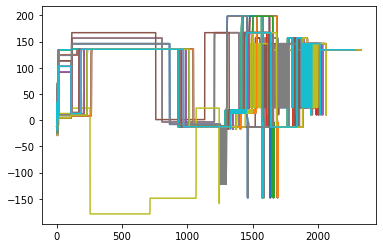

In [7]:
for i in range(len(plot)):
    plt.plot(range(len(plot[i])),plot[i])

In [8]:
mean_reward_dqn

193733.81391217842

We see that the results are quite similar in most executions in the environment

In [7]:
v = []
p = []
l = []
g = []
r = []
rev = []
done = False
rewards = []
model = DQN.load("deepq_fuel")
obs = env.reset()
while done == False:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print(obs, reward, done, info)
    v.append(obs[1])
    p.append(obs[0])
    l.append(obs[5])
    rev.append(obs[3])
    g.append(obs[2])
    r.append(reward)

    if done:
      rewards.append(r)
      obs = env.reset()


[  1.6668    6.        1.      633.87976  10.1874  113.     ] -13.046197814207648 False {}
[5.0004001e+00 1.2000000e+01 1.0000000e+00 1.2677595e+03 9.7103996e+00
 1.1300000e+02] -15.427995628415296 False {}
[1.0000800e+01 1.8000000e+01 1.0000000e+00 1.9016394e+03 9.6582003e+00
 1.1300000e+02] -18.234593442622952 False {}
[1.666800e+01 2.400000e+01 1.000000e+00 2.535519e+03 1.003080e+01
 1.130000e+02] 33.169200000000004 False {}
[2.500200e+01 3.000000e+01 1.000000e+00 3.169399e+03 1.082820e+01
 1.130000e+02] -25.12218907103825 False {}
[  33.336    30.        2.     1774.8634    5.9668  113.    ] -6.315433879781416 False {}
[4.3336800e+01 3.6000000e+01 2.0000000e+00 2.1298362e+03 6.0976000e+00
 1.1300000e+02] 58.7024 False {}
[5.5004398e+01 4.2000000e+01 2.0000000e+00 2.4848088e+03 6.3147998e+00
 1.1300000e+02] 69.2852 False {}
[6.8338799e+01 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 1.1300000e+02] 79.78160000000001 False {}
[8.3339996e+01 5.4000000e+01 2.0000000e+00 3.19

[3751.9668   78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3773.6353   78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3795.3037   78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3816.972    78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3838.6404   78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3860.3088   78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3881.9773   78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3903.6455   78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3925.314    78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3946.9824   78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3968.651    78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[3990.319    78.        4.     2307.3225    4.8648  120.    ] 135.5352 False {}
[4.0119875e+03 7.8000000e+01 4.0000000e+

[7.0889004e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[7.1105688e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[7.1322373e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[7.1539058e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[7.1755742e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[7.1972422e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[7.2189106e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[7.2405791e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[7.2622476e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[7.2839160e+03 7.8000000e+01 4.0000000e+00 2.3073225e+0

[1.0772528e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.0794197e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.0815865e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.0837533e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.0859202e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.0880870e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.0902539e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.0924207e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.0945876e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.0967544e+04 7.8000000e+01 4.0000000e+00 2.3073225e+0

 1.0000000e+02] 135.5352 False {}
[1.4066125e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.4087794e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.4109462e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.4131131e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.4152799e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.4174467e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.4196136e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.4217804e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.4239473e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.4261141e+04 7.8000

 1.0000000e+02] 135.5352 False {}
[1.7554738e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.7576406e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.7598074e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.7619742e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.7641412e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.7663080e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.7684748e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.7706416e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.7728084e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.0000000e+02] 135.5352 False {}
[1.7749754e+04 7.8000

 7.0000000e+01] -12.464799999999997 False {}
[2.0371629e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.0393299e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.0414967e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.0436635e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.0458303e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.0479971e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.0501641e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.0523309e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.0544977e+04 7.8000000e+0

 7.0000000e+01] -12.464799999999997 False {}
[2.5507041e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.5528709e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.5550377e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.5572045e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.5593715e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.5615383e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.5637051e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.5658719e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[2.5680387e+04 7.8000000e+0

 7.0000000e+01] 14.323702732240434 False {}
[2.8535615e+04 6.6000000e+01 5.0000000e+00 1.5339890e+03 4.1613002e+00
 7.0000000e+01] 18.778809289617485 False {}
[2.8553951e+04 6.6000000e+01 4.0000000e+00 1.9523497e+03 4.4327998e+00
 7.0000000e+01] 14.323702732240434 False {}
[2.8572285e+04 6.6000000e+01 5.0000000e+00 1.5339890e+03 4.1613002e+00
 7.0000000e+01] 18.778809289617485 False {}
[2.8590621e+04 6.6000000e+01 4.0000000e+00 1.9523497e+03 4.4327998e+00
 7.0000000e+01] 14.323702732240434 False {}
[2.8608955e+04 6.6000000e+01 5.0000000e+00 1.5339890e+03 4.1613002e+00
 7.0000000e+01] 18.778809289617485 False {}
[2.8627289e+04 6.6000000e+01 4.0000000e+00 1.9523497e+03 4.4327998e+00
 7.0000000e+01] 14.323702732240434 False {}
[2.8645625e+04 6.6000000e+01 5.0000000e+00 1.5339890e+03 4.1613002e+00
 7.0000000e+01] 18.778809289617485 False {}
[2.8663959e+04 6.6000000e+01 4.0000000e+00 1.9523497e+03 4.4327998e+00
 7.0000000e+01] 14.323702732240434 False {}
[2.8682295e+04 6.6000000e+01 5.00000

[3.2679281e+04 1.1400000e+02 5.0000000e+00 2.6496174e+03 6.7389002e+00
 1.4000000e+02] 198.46110000000002 False {}
[3.2710949e+04 1.1400000e+02 5.0000000e+00 2.6496174e+03 6.7389002e+00
 1.4000000e+02] 198.46110000000002 False {}
[3.2742619e+04 1.1400000e+02 5.0000000e+00 2.6496174e+03 6.7389002e+00
 1.4000000e+02] 198.46110000000002 False {}
[3.2774289e+04 1.1400000e+02 5.0000000e+00 2.6496174e+03 6.7389002e+00
 1.4000000e+02] 198.46110000000002 False {}
[3.2805957e+04 1.1400000e+02 5.0000000e+00 2.6496174e+03 6.7389002e+00
 1.4000000e+02] 198.46110000000002 False {}
[3.2837625e+04 1.1400000e+02 5.0000000e+00 2.6496174e+03 6.7389002e+00
 1.4000000e+02] 198.46110000000002 False {}
[3.2869297e+04 1.1400000e+02 5.0000000e+00 2.6496174e+03 6.7389002e+00
 1.4000000e+02] 198.46110000000002 False {}
[3.2900965e+04 1.1400000e+02 5.0000000e+00 2.6496174e+03 6.7389002e+00
 1.4000000e+02] 198.46110000000002 False {}
[3.2932633e+04 1.1400000e+02 5.0000000e+00 2.6496174e+03 6.7389002e+00
 1.400000

[3.6231230e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 8.0000000e+01] -13.219699999999989 False {}
[3.6256234e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 8.0000000e+01] -13.219699999999989 False {}
[3.6281234e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 8.0000000e+01] -13.219699999999989 False {}
[3.6306238e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 8.0000000e+01] -13.219699999999989 False {}
[3.6331238e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 8.0000000e+01] -13.219699999999989 False {}
[3.6356242e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 8.0000000e+01] -13.219699999999989 False {}
[3.6381242e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 8.0000000e+01] -13.219699999999989 False {}
[3.6406246e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 8.0000000e+01] -13.219699999999989 False {}
[3.6431246e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 

 8.0000000e+01] -13.219699999999989 False {}
[4.0006535e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 9.0000000e+01] 156.588 False {}
[4.0031535e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 9.0000000e+01] 156.7803 False {}
[4.0056539e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 9.0000000e+01] 156.588 False {}
[4.0081539e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 9.0000000e+01] 156.7803 False {}
[4.0106543e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 9.0000000e+01] 156.588 False {}
[4.0131543e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 9.0000000e+01] 156.7803 False {}
[4.0156547e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 9.0000000e+01] 156.588 False {}
[4.0181547e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 9.0000000e+01] 156.7803 False {}
[4.0206551e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 9.0000000e+01] 156.588 False {}
[4.0231551e+04 

 9.0000000e+01] 146.07600000000002 False {}
[4.3236793e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 9.0000000e+01] 146.07600000000002 False {}
[4.3260129e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 9.0000000e+01] 146.07600000000002 False {}
[4.3283461e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 9.0000000e+01] 146.07600000000002 False {}
[4.3306797e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 9.0000000e+01] 146.07600000000002 False {}
[4.3330133e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 9.0000000e+01] 146.07600000000002 False {}
[4.3353469e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 9.0000000e+01] 146.07600000000002 False {}
[4.3376805e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 9.0000000e+01] 146.07600000000002 False {}
[4.3400137e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 9.0000000e+01] 146.07600000000002 False {}
[4.3423473e+04 8.4000000e+01 4.00000

[4.7987172e+04 7.8000000e+01 3.0000000e+00 2.9665574e+03 5.9856000e+00
 9.0000000e+01] 134.4144 False {}
[4.8008840e+04 7.8000000e+01 3.0000000e+00 2.9665574e+03 5.9856000e+00
 9.0000000e+01] 134.4144 False {}
[4.8030508e+04 7.8000000e+01 3.0000000e+00 2.9665574e+03 5.9856000e+00
 9.0000000e+01] 134.4144 False {}
[4.8052176e+04 7.8000000e+01 3.0000000e+00 2.9665574e+03 5.9856000e+00
 9.0000000e+01] 134.4144 False {}
[4.8073844e+04 7.8000000e+01 3.0000000e+00 2.9665574e+03 5.9856000e+00
 9.0000000e+01] 134.4144 False {}
[4.8095516e+04 7.8000000e+01 3.0000000e+00 2.9665574e+03 5.9856000e+00
 9.0000000e+01] 134.4144 False {}
[4.8117184e+04 7.8000000e+01 3.0000000e+00 2.9665574e+03 5.9856000e+00
 9.0000000e+01] 134.4144 False {}
[4.8138852e+04 7.8000000e+01 3.0000000e+00 2.9665574e+03 5.9856000e+00
 9.0000000e+01] 134.4144 False {}
[4.8160520e+04 7.8000000e+01 3.0000000e+00 2.9665574e+03 5.9856000e+00
 9.0000000e+01] 134.4144 False {}
[4.8182188e+04 7.8000000e+01 3.0000000e+00 2.9665574e+0

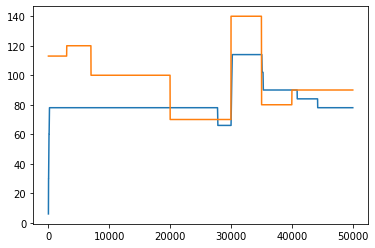

In [8]:
plt.plot(p,v)
plt.plot(p,l)

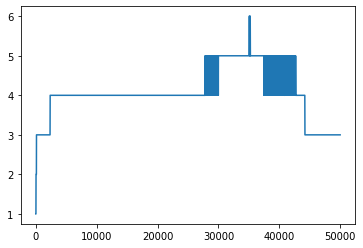

In [9]:
plt.plot(p, g)

In this case we can see how the agent adapts to the speed limits and how it changes, it tries to always use higher gears to save fuel and make driving more autonomous but it needs me to risk more to go up the speed in this case.

## Changing the environment

Now we are going to change the speed limits of the circuit to see if the agent is able to adapt to the new environment

In [4]:
# I changed the environment speed limits that's why I call it again
env = gym.make("Fuel-v0")
v = []
p = []
l = []
g = []
r = []
rev = []
done = False
rewards = []
model = DQN.load("deepq_fuel")
obs = env.reset()
while done == False:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    print(obs, reward, done, info)
    v.append(obs[1])
    p.append(obs[0])
    l.append(obs[5])
    rev.append(obs[3])
    g.append(obs[2])
    r.append(reward)

    if done:
      rewards.append(r)
      obs = env.reset()

mean_reward_dqn, plot = evaluate_to_plot(model, env,num_episodes=50)








Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




[  1.6668    6.        1.      633.87976  10.1874  113.     ] -13.046197814207648 False {}
[5.0004001e+00 1.2000000e+01 1.0000000e+00 1.2677595e+03 9.7103996e+00
 1.1300000e+02] -15.427995628415296 False {}
[1.0000800e+01 1.8000000e+01 1.0000000e+00 1.9016394e+03 9.6582003e+00
 1.1300000e+02] -18.234593442622952 False {}
[1.666800e+01 2.400000e+01 1.000000e+00 2.535519e+03 1.003080e+01
 1.130000e+02] 33.169200000000004 False {}
[2.500200e+01 3.000000e+01 1.000000e+00 3.169399e+03 1.082820e+01
 1.130000e+02] -25.12218907103825 False {}
[  33.336    30.        2.     1774.8634    5.9668  113.    ] -6.315433879781416 False {}
[4.3336800e+01 3.6000000e+01 2.0000000e+00 2.1298362e+03 6.0976000e+00
 1.1300000e+02] 58.7024 False {}
[5.5004398e+01 4.2000000e+01 2.0000000e+00 2.4848088e+03 6.3147998e+00
 1.1300000e+02] 69.2852 False {}
[6.8338799e+01 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 1.1300000e+02] 79.78160000000001 False {}
[8.3339996e+01 5.4000000e+01 2.0000000e+00 3.

 1.2000000e+02] 135.5352 False {}
[4.0986611e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[4.1203296e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[4.1419980e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[4.1636665e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[4.1853350e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[4.2070034e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[4.2286714e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[4.2503398e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[4.2720083e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[4.2936768e+03 7.8000

[7.6739473e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[7.6956157e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[7.7172842e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[7.7389526e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[7.7606206e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[7.7822891e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[7.8039575e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[7.8256260e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[7.8472944e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[7.8689629e+03 7.8000000e+01 4.0000000e+00 2.3073225e+0

[1.0230818e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.0252486e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.0274155e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.0295823e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.0317492e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.0339160e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.0360829e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.0382497e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.0404166e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.0425834e+04 7.8000000e+01 4.0000000e+00 2.3073225e+0

[1.4109462e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.4131131e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.4152799e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.4174467e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.4196136e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.4217804e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.4239473e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.4261141e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.4282810e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.4304478e+04 7.8000000e+01 4.0000000e+00 2.3073225e+0

 1.2000000e+02] 135.5352 False {}
[1.8118115e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.8139785e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.8161453e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.8183121e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.8204789e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.8226457e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.8248127e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.8269795e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.8291463e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[1.8313131e+04 7.8000

[2.1541723e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.1563391e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.1585061e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.1606729e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.1628396e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.1650064e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.1671734e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.1693402e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.1715070e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.1736738e+04 7.8000000e+01 4.0000000e+00 2.3073225e+0

 1.2000000e+02] 146.07600000000002 False {}
[2.4646971e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.4670307e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.4693643e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.4716977e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.4740312e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.4763648e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.4786982e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.4810318e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.4833652e+04 8.4000000e+01 4.00000

[2.9267342e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.9290676e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.9314012e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.9337348e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.9360682e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.9384018e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.9407352e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.9430688e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.9454023e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.200000

 1.2000000e+02] 146.07600000000002 False {}
[3.2347588e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[3.2370922e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[3.2394258e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[3.2417594e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[3.2440928e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[3.2464264e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[3.2487600e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[3.2510934e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[3.2534270e+04 8.4000000e+01 4.00000

 1.2000000e+02] 156.588 False {}
[3.5444504e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.5469504e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 1.2000000e+02] 156.588 False {}
[3.5494508e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.5519508e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 1.2000000e+02] 156.588 False {}
[3.5544512e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.5569512e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 1.2000000e+02] 156.588 False {}
[3.5594516e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.5619516e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 1.2000000e+02] 156.588 False {}
[3.5644520e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.5669520e+04 9.0000000e+

 1.2000000e+02] 156.588 False {}
[3.8194723e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.8219723e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 1.2000000e+02] 156.588 False {}
[3.8244727e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.8269727e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 1.2000000e+02] 156.588 False {}
[3.8294730e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.8319730e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 1.2000000e+02] 156.588 False {}
[3.8344734e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.8369734e+04 9.0000000e+01 4.0000000e+00 2.6622952e+03 5.4120002e+00
 1.2000000e+02] 156.588 False {}
[3.8394738e+04 9.0000000e+01 5.0000000e+00 2.0918032e+03 5.2196999e+00
 1.2000000e+02] 156.7803 False {}
[3.8419738e+04 9.0000000e+

 1.200000e+02] 11.22529180327868 False {}
[4.304511e+04 9.000000e+01 3.000000e+00 3.422951e+03 6.745200e+00
 1.200000e+02] 11.22529180327868 False {}
[4.3070113e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.3095113e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.3120117e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.3145117e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.317012e+04 9.000000e+01 3.000000e+00 3.422951e+03 6.745200e+00
 1.200000e+02] 11.22529180327868 False {}
[4.319512e+04 9.000000e+01 3.000000e+00 3.422951e+03 6.745200e+00
 1.200000e+02] 11.22529180327868 False {}
[4.3220125e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.3245125e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.74520

[4.6370375e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.639538e+04 9.000000e+01 3.000000e+00 3.422951e+03 6.745200e+00
 1.200000e+02] 11.22529180327868 False {}
[4.642038e+04 9.000000e+01 3.000000e+00 3.422951e+03 6.745200e+00
 1.200000e+02] 11.22529180327868 False {}
[4.6445383e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.6470383e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.6495387e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.6520387e+04 9.0000000e+01 3.0000000e+00 3.4229509e+03 6.7452002e+00
 1.2000000e+02] 11.22529180327868 False {}
[4.654539e+04 9.000000e+01 3.000000e+00 3.422951e+03 6.745200e+00
 1.200000e+02] 11.22529180327868 False {}
[4.657039e+04 9.000000e+01 3.000000e+00 3.422951e+03 6.745200e+00
 1.200000e+02] 11.22529180327868 False {

[256110.03393879594, 246103.1779387953, 255065.50563606367, 248630.77819453142, 257336.13770600926, 275426.69721584854, 263176.8773442638, 246103.1779387953, 257237.0314087415, 256110.03393879594, 263156.9310622965, 263066.3521945367, 263169.0774622965, 246107.38406557127, 246626.86249289368, 254903.36289508006, 248776.14090272813, 246206.69886884996, 257435.24400327704, 263190.4063475425, 257336.13770600926, 249666.65767704873, 263176.8773442638, 255213.13500983416, 263065.23139453674, 263169.0774622965, 246154.37206338547, 248362.45196502327, 257435.24400327704, 246201.92623824885, 275581.77889125835, 248630.77819453142, 263066.3521945367, 256200.12637267573, 275581.77889125835, 250049.65795355148, 248485.4154863347, 254984.43426557188, 263169.0774622965, 263065.23139453674, 246107.38406557127, 246107.38406557127, 249914.00701256786, 250049.65795355148, 256200.12637267573, 275581.77889125835, 255213.13500983416, 246626.86249289368, 246211.47149945103, 246206.69886884996]
Mean reward:

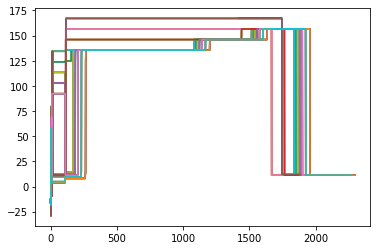

In [5]:
for i in range(len(plot)):
    plt.plot(range(len(plot[i])),plot[i])

In [6]:
mean_reward_dqn

255615.04319516825

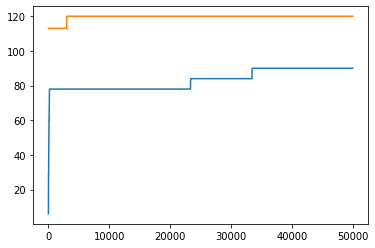

In [7]:
plt.plot(p,v)
plt.plot(p,l)

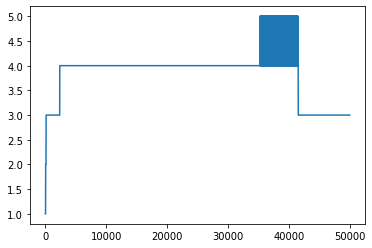

In [8]:
plt.plot(p, g)

In this case, the environment is easier since we have fewer speed limits and we see how the gear change does it well but there is little risk when it comes to increasing speed.

In [4]:
# I changed the environment speed limits that's why I call it again
env = gym.make("Fuel-v0")
v = []
p = []
l = []
g = []
r = []
rev = []
done = False
rewards = []
model = DQN.load("deepq_fuel")
obs = env.reset()
while done == False:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print(obs, reward, done, info)
    v.append(obs[1])
    p.append(obs[0])
    l.append(obs[5])
    rev.append(obs[3])
    g.append(obs[2])
    r.append(reward)

    if done:
      rewards.append(r)
      obs = env.reset()

mean_reward_dqn, plot = evaluate_to_plot(model,env, num_episodes=50)








Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




[  1.6668    6.        1.      633.87976  10.1874  113.     ] -13.046197814207648 False {}
[5.0004001e+00 1.2000000e+01 1.0000000e+00 1.2677595e+03 9.7103996e+00
 1.1300000e+02] -15.427995628415296 False {}
[1.0000800e+01 1.8000000e+01 1.0000000e+00 1.9016394e+03 9.6582003e+00
 1.1300000e+02] -18.234593442622952 False {}
[1.666800e+01 2.400000e+01 1.000000e+00 2.535519e+03 1.003080e+01
 1.130000e+02] 33.169200000000004 False {}
[2.500200e+01 3.000000e+01 1.000000e+00 3.169399e+03 1.082820e+01
 1.130000e+02] -25.12218907103825 False {}
[  33.336    30.        2.     1774.8634    5.9668  113.    ] -6.315433879781416 False {}
[4.3336800e+01 3.6000000e+01 2.0000000e+00 2.1298362e+03 6.0976000e+00
 1.1300000e+02] 58.7024 False {}
[5.5004398e+01 4.2000000e+01 2.0000000e+00 2.4848088e+03 6.3147998e+00
 1.1300000e+02] 69.2852 False {}
[6.8338799e+01 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 1.1300000e+02] 79.78160000000001 False {}
[8.3339996e+01 5.4000000e+01 2.0000000e+00 3.

[ 740.0592   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 761.7276   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 783.396    78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 805.0644   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 826.7328   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 848.4012   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 870.0696   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 891.738    78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 913.4064   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 935.0748   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 956.7432   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[ 978.4116   78.        3.     2966.5574    5.9856  113.    ] 134.4144 False {}
[1000.08     78.        3.     2966.5574

 8.0000000e+01] 135.5352 False {}
[4.8353867e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 8.0000000e+01] 135.5352 False {}
[4.8570552e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 8.0000000e+01] 135.5352 False {}
[4.8787236e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 8.0000000e+01] 135.5352 False {}
[4.9003921e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 8.0000000e+01] 135.5352 False {}
[4.9220605e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 8.0000000e+01] 135.5352 False {}
[4.9437290e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 8.0000000e+01] 135.5352 False {}
[4.9653970e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 8.0000000e+01] 135.5352 False {}
[4.9870654e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 8.0000000e+01] 135.5352 False {}
[5.0087339e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 8.0000000e+01] 135.5352 False {}
[5.0304023e+03 7.8000

[8.1073154e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[8.1289834e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[8.1506519e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[8.1723203e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[8.1939893e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[8.2156572e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[8.2373252e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[8.2589941e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[8.2806621e+03 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 

[1.1054218e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.1075886e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.1097555e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.1119223e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.1140892e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.1162560e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.1184228e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.1205896e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.1227564e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 

[1.3676094e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.3697763e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.3719431e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.3741100e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.3762768e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.3784436e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.38061045e+04 7.80000000e+01 4.00000000e+00 2.30732251e+03
 4.86479998e+00 7.00000000e+01] -12.464799999999997 False {}
[1.3827772e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.3849441e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000

 7.0000000e+01] -12.464799999999997 False {}
[1.7099701e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.7121369e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.7143037e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.7164707e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.7186375e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.7208043e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.7229711e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.7251381e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 7.0000000e+01] -12.464799999999997 False {}
[1.7273049e+04 7.8000000e+0

 1.2000000e+02] 135.5352 False {}
[2.0133277e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.0154945e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.0176613e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.0198283e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.0219951e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.0241619e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.0263287e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.0284955e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.0306625e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.0328293e+04 7.8000

 1.2000000e+02] 135.5352 False {}
[2.3340201e+04 7.8000000e+01 4.0000000e+00 2.3073225e+03 4.8648000e+00
 1.2000000e+02] 135.5352 False {}
[2.3363535e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.3386871e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.3410205e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.3433541e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.3456877e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.3480211e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.3503547e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.3526883e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03

 1.2000000e+02] 146.07600000000002 False {}
[2.7820559e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.7843895e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.7867229e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.7890564e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.7913900e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.7937234e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.7960570e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.7983904e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.2000000e+02] 146.07600000000002 False {}
[2.8007240e+04 8.4000000e+01 4.00000

[3.1390844e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.1414180e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.1437516e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.1460850e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.1484186e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.1507520e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.1530855e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.1554191e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.1577525e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.000000

 1.0000000e+02] 24.284602732240444 False {}
[3.4447754e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.4471090e+04 8.4000000e+01 5.0000000e+00 1.9523497e+03 4.9119000e+00
 1.0000000e+02] 24.284602732240444 False {}
[3.4494426e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.4517762e+04 8.4000000e+01 5.0000000e+00 1.9523497e+03 4.9119000e+00
 1.0000000e+02] 24.284602732240444 False {}
[3.4541098e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.4564430e+04 8.4000000e+01 5.0000000e+00 1.9523497e+03 4.9119000e+00
 1.0000000e+02] 24.284602732240444 False {}
[3.4587766e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 1.0000000e+02] 146.07600000000002 False {}
[3.4611102e+04 8.4000000e+01 5.0000000e+00 1.9523497e+03 4.9119000e+00
 1.0000000e+02] 24.284602732240444 False {}
[3.4634438e+04 8.4000000e+01 4.00000

 7.0000000e+01] -129.71539726775956 False {}
[3.9394816e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 7.0000000e+01] -7.923999999999978 False {}
[3.9418152e+04 8.4000000e+01 5.0000000e+00 1.9523497e+03 4.9119000e+00
 7.0000000e+01] -129.71539726775956 False {}
[3.9441488e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 7.0000000e+01] -7.923999999999978 False {}
[3.9464824e+04 8.4000000e+01 5.0000000e+00 1.9523497e+03 4.9119000e+00
 7.0000000e+01] -129.71539726775956 False {}
[3.9488160e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 7.0000000e+01] -7.923999999999978 False {}
[3.9511492e+04 8.4000000e+01 5.0000000e+00 1.9523497e+03 4.9119000e+00
 7.0000000e+01] -129.71539726775956 False {}
[3.9534828e+04 8.4000000e+01 4.0000000e+00 2.4848088e+03 5.1240001e+00
 7.0000000e+01] -7.923999999999978 False {}
[3.9558164e+04 8.4000000e+01 5.0000000e+00 1.9523497e+03 4.9119000e+00
 7.0000000e+01] -129.71539726775956 False {}
[3.9581500e+04 8.4000000e+01 4.

[4.2076699e+04 5.4000000e+01 3.0000000e+00 2.0537705e+03 4.8983998e+00
 5.0000000e+01] -11.698399999999992 False {}
[4.2091699e+04 5.4000000e+01 2.0000000e+00 3.1947542e+03 7.0084000e+00
 5.0000000e+01] -111.63594098360655 False {}
[4.2106703e+04 5.4000000e+01 3.0000000e+00 2.0537705e+03 4.8983998e+00
 5.0000000e+01] -11.698399999999992 False {}
[4.2121703e+04 5.4000000e+01 2.0000000e+00 3.1947542e+03 7.0084000e+00
 5.0000000e+01] -111.63594098360655 False {}
[4.2136703e+04 5.4000000e+01 3.0000000e+00 2.0537705e+03 4.8983998e+00
 5.0000000e+01] -11.698399999999992 False {}
[4.2151707e+04 5.4000000e+01 2.0000000e+00 3.1947542e+03 7.0084000e+00
 5.0000000e+01] -111.63594098360655 False {}
[4.2166707e+04 5.4000000e+01 3.0000000e+00 2.0537705e+03 4.8983998e+00
 5.0000000e+01] -11.698399999999992 False {}
[4.2181707e+04 5.4000000e+01 2.0000000e+00 3.1947542e+03 7.0084000e+00
 5.0000000e+01] -111.63594098360655 False {}
[4.2196707e+04 5.4000000e+01 3.0000000e+00 2.0537705e+03 4.8983998e+00
 

[4.3975184e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.3988520e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.4001852e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.4015188e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.4028523e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.4041855e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.4055191e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.4068523e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.4081859e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 7

 5.0000000e+01] 79.78160000000001 False {}
[4.5868668e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.5882004e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.5895340e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.5908672e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.5922008e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.5935340e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.5948676e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.5962012e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.5975344e+04 4.8000000e+01 2.0000000e+00 2.

 5.0000000e+01] 79.78160000000001 False {}
[4.8282195e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.8295531e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.8308863e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.8322199e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.8335531e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.8348867e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.8362203e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.8375535e+04 4.8000000e+01 2.0000000e+00 2.8397815e+03 6.6184001e+00
 5.0000000e+01] 79.78160000000001 False {}
[4.8388871e+04 4.8000000e+01 2.0000000e+00 2.

[122552.25748196914, 112280.09744262538, 121049.56879890997, 103675.74506667013, 124009.24023934602, 105449.39960492087, 130584.17624481308, 112280.09744262538, 123910.13394207828, 122552.25748196914, 130685.58396284585, 133910.46709508242, 134013.19236284198, 112284.30356940132, 113082.91039672373, 120887.42605792636, 103821.10777486686, 112662.74677268001, 124108.34653661377, 130597.70524809178, 124009.24023934602, 95281.92286120394, 130584.17624481308, 121197.19817268045, 133909.34629508245, 134013.19236284198, 112610.41996721552, 103407.41883716192, 124108.34653661377, 112657.9741420789, 105604.48128033073, 103675.74506667013, 133910.46709508242, 122642.34991584891, 105604.48128033073, 95664.92313770673, 103530.3823584734, 120968.49742841817, 134013.19236284198, 133909.34629508245, 112284.30356940132, 112284.30356940132, 95529.2721967231, 95664.92313770673, 122642.34991584891, 105604.48128033073, 121197.19817268045, 113082.91039672373, 112667.5194032811, 112662.74677268001]
Mean re

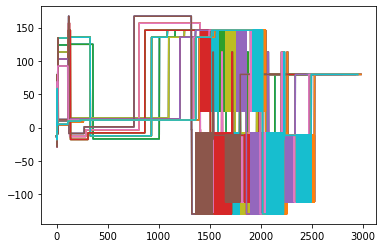

In [5]:
for i in range(len(plot)):
    plt.plot(range(len(plot[i])),plot[i])

In [6]:
mean_reward_dqn

116986.39747635204

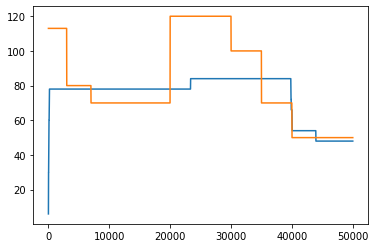

In [4]:
plt.plot(p,v)
plt.plot(p,l)

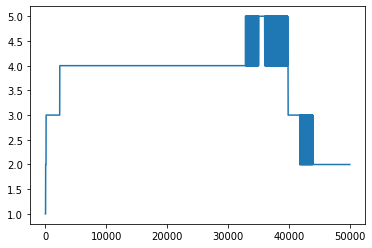

In [5]:
plt.plot(p, g)

It does not do his job as well since he has been trained in a different environment, therefore it is normal for performance to decrease

## Conclusions

We have seen that the agent works quite well in most cases. We have also seen that there are easier and more difficult environments, for example, the more abrupt and more speed limit changes, the more difficult it will be for the agent to obtain good results and vice versa. In the latter case we see that he gets better results than in the same environment where he has been trained.
We can conclude that the agent fulfills its work and with the objective with which it was programmed.

## Unittests
I have used the tests they use in open gym to see if the environment was correct. (https://github.com/openai/gym/blob/master/tests/envs/test_envs.py)

In [4]:
import numpy as np

from gym import envs
from gym.spaces import Box
from stable_baselines.common.env_checker import check_env

def test_env():
    env = gym.make("Fuel-v0")
    # Test if env adheres to Gym API
    #check_env(env, warn=True, skip_render_check=True)

    ob_space = env.observation_space
    act_space = env.action_space
    ob = env.reset()
    assert ob_space.contains(ob), f"Reset observation: {ob!r} not in space"
    if isinstance(ob_space, Box):
        # Only checking dtypes for Box spaces to avoid iterating through tuple entries
        assert (
            ob.dtype == ob_space.dtype
        ), f"Reset observation dtype: {ob.dtype}, expected: {ob_space.dtype}"

    a = act_space.sample()
    observation, reward, done, _info = env.step(a)
    assert ob_space.contains(
        observation
    ), f"Step observation: {observation!r} not in space"
    assert np.isscalar(reward), f"{reward} is not a scalar for {env}"
    assert isinstance(done, bool), f"Expected {done} to be a boolean"
    if isinstance(ob_space, Box):
        assert (
            observation.dtype == ob_space.dtype
        ), f"Step observation dtype: {ob.dtype}, expected: {ob_space.dtype}"


    env.close()

In [5]:
def test_reset_info():

    env = gym.make("Fuel-v0")
    ob_space = env.observation_space
    obs = env.reset()
    assert ob_space.contains(obs)
    obs = env.reset(return_info=False)
    assert ob_space.contains(obs)
    obs, info = env.reset(return_info=True)
    assert ob_space.contains(obs)
    assert isinstance(info, dict)
    env.close()

In [6]:
def test_random_rollout():
    env = gym.make("Fuel-v0")
    agent = lambda ob: env.action_space.sample()
    ob = env.reset()
    for _ in range(10):
        assert env.observation_space.contains(ob)
        a = agent(ob)
        assert env.action_space.contains(a)
        (ob, _reward, done, _info) = env.step(a)
        if done:
            break

In [7]:
test_env()

In [8]:
test_reset_info()

In [9]:
test_random_rollout()